Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

/content/drive/My Drive/  目錄內資料
 _backup      CAMELYON17	 Data_Face   Data_RGBD	 Data_Slide
 CAMELYON16  'Colab Notebooks'	 Data_old    _DataSets	 video

查看當前工作目錄路徑 : /content
查看當前工作目錄路徑內資料
drive  sample_data

更改當前工作目錄至 /content/drive/My Drive/Colab Notebooks
查看更改後之當前工作目錄路徑 : /content/drive/My Drive/Colab Notebooks
查看更改後之當前工作目錄路徑內資料
'Copy of Copy of efficientnet_sample_macOS_1090625trainOK_jp.ipynb'
'Copy of efficientnet_sample_macOS_1090625trainOK_jp (1).ipynb'
'Copy of efficientnet_sample_macOS_1090625trainOK_jp (2).ipynb'
'Copy of efficientnet_sample_macOS_1090625trainOK_jp (3).ipynb'
'Copy of efficientnet_sample_macOS_1090625trainOK_jp (4).ipynb'
'Copy of efficientnet_sample_macOS_1090625trainOK_jp.ipynb'
 eff_weights
'OxFlower17_from Baidu'

Python verion
Python 3.6.9

安裝環境
Data Size 1020
Epoch 0/29
----------
LR is set to 0.01
Epoch:0: loss:1.183
Epoch

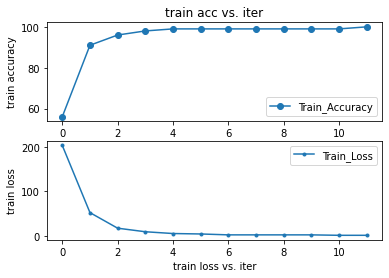

Training complete in 0m 59s
----------
Test Accuracy:
Loss: 0.1034 Acc: 0.9706


In [1]:
# %load efficientnet_sample_macOS_1090625trainOK.py
from __future__ import print_function, division

from google.colab import drive
drive.mount('/content/drive')

print('\n/content/drive/My Drive/  目錄內資料')
!ls '/content/drive/My Drive/'

import os, time
print("\n查看當前工作目錄路徑 : %s" % os.getcwd() )
print('查看當前工作目錄路徑內資料')
!ls

print('\n更改當前工作目錄至 /content/drive/My Drive/Colab Notebooks')
os.chdir("/content/drive/My Drive/Colab Notebooks")  #更改路徑

print("查看更改後之當前工作目錄路徑 : %s" % os.getcwd())   #查看當前路徑
print('查看更改後之當前工作目錄路徑內資料')
!ls           #查看當前目錄


#查詢Python版本
print('\nPython verion')
!python -V                         #Python (3.6.9)

#安裝套件
print ('\n安裝環境')
!pip install efficientnet_pytorch  #efficientnet_pytorch (1.5.1+cu101)
!pip install torchvision           #torchvision (0.6.1+cu101
!pip install matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, models, transforms
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt


# some parameters
use_gpu = torch.cuda.is_available()
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
data_dir = 'OxFlower17_from Baidu'
batch_size = 32
lr = 0.01
momentum = 0.9
num_epochs = 30
input_size = 224
class_num = 17
net_name = 'efficientnet-b0'



def loaddata(data_dir, batch_size, set_name, shuffle):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in [set_name]}
    # num_workers=0 if CPU else =1
    dataset_loaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                                    batch_size=batch_size,
                                                    shuffle=shuffle, num_workers=1) for x in [set_name]}
    data_set_sizes = len(image_datasets[set_name])
    return dataset_loaders, data_set_sizes


def train_model(model_ft, criterion, optimizer, lr_scheduler, num_epochs):
    train_loss = []
    loss_all = []    #109.6.19 add, ref:https://blog.csdn.net/Whisper_lg/article/details/106567721
    acc_all = []     #109.6.19 add, ref:https://blog.csdn.net/Whisper_lg/article/details/106567721
    since = time.time()
    best_model_wts = model_ft.state_dict()
    best_acc = 0.0
    model_ft.train(True)
    for epoch in range(num_epochs):
        dset_loaders, dset_sizes = loaddata(data_dir=data_dir, batch_size=batch_size, set_name='train', shuffle=True)
        print('Data Size', dset_sizes)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        optimizer = lr_scheduler(optimizer, epoch)

        running_loss = 0.0
        running_corrects = 0
        count = 0

        for data in dset_loaders['train']:
            inputs, labels = data
            labels = torch.squeeze(labels.type(torch.LongTensor))
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            outputs = model_ft(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs.data, 1)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            count += 1
            if count % 30 == 0 or outputs.size()[0] < batch_size:
                print('Epoch:{}: loss:{:.3f}'.format(epoch, loss.item()))
                train_loss.append(loss.item())

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dset_sizes
        epoch_acc = running_corrects.double() / dset_sizes
        loss_all.append(int(epoch_loss*100))               #109.6.19 add, ref:https://blog.csdn.net/Whisper_lg/article/details/106567721
        acc_all.append(int(epoch_acc*100))                 #109.6.19 add, ref:https://blog.csdn.net/Whisper_lg/article/details/106567721

        print('Loss: {:.4f} Acc: {:.4f}'.format(
            epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model_ft.state_dict()
        if epoch_acc > 0.999:
            break

    # save best model
    save_dir = data_dir + '/model'
    model_ft.load_state_dict(best_model_wts)
    model_out_path = save_dir + "/" + net_name + 'pth'
    torch.save(model_ft, model_out_path)

    # ---------109.6.19 add, ref:https://blog.csdn.net/Whisper_lg/article/details/106567721
    # plot the figure of acc and loss
    x1 = list(range(len(acc_all)))
    x2 = list(range(len(loss_all)))
    y1 = acc_all
    y2 = loss_all
    plt.subplot(2, 1, 1)
    # plt.plot(x1, y1, 'o-',color='r')
    plt.plot(x1, y1, 'o-', label="Train_Accuracy")
    plt.title('train acc vs. iter')
    plt.ylabel('train accuracy')
    plt.legend(loc='best')
    plt.subplot(2, 1, 2)
    plt.plot(x2, y2, '.-', label="Train_Loss")
    plt.xlabel('train loss vs. iter')
    plt.ylabel('train loss')
    plt.legend(loc='best')
    plt.savefig(save_dir + "/"+"acc_loss.png")
    plt.show()
    # -------------------------------------------------------------------------------------

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return train_loss, best_model_wts


def test_model(model, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    cont = 0
    outPre = []
    outLabel = []
    dset_loaders, dset_sizes = loaddata(data_dir=data_dir, batch_size=16, set_name='test', shuffle=False)
    for data in dset_loaders['test']:
        inputs, labels = data
        labels = torch.squeeze(labels.type(torch.LongTensor))
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        if cont == 0:
            outPre = outputs.data.cpu()
            outLabel = labels.data.cpu()
        else:
            outPre = torch.cat((outPre, outputs.data.cpu()), 0)
            outLabel = torch.cat((outLabel, labels.data.cpu()), 0)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        cont += 1
    print('Loss: {:.4f} Acc: {:.4f}'.format(running_loss / dset_sizes,
                                            running_corrects.double() / dset_sizes))


def exp_lr_scheduler(optimizer, epoch, init_lr=lr, lr_decay_epoch=10):
    """Decay learning rate by a f#            model_out_path ="./model/W_epoch_{}.pth".format(epoch)
#            torch.save(model_W, model_out_path) actor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.8**(epoch // lr_decay_epoch))
    print('LR is set to {}'.format(lr))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer


# train
pth_map = {
    'efficientnet-b0': 'efficientnet-b0-355c32eb.pth',
    'efficientnet-b1': 'efficientnet-b1-f1951068.pth',
    'efficientnet-b2': 'efficientnet-b2-8bb594d6.pth',
    'efficientnet-b3': 'efficientnet-b3-5fb5a3c3.pth',
    'efficientnet-b4': 'efficientnet-b4-6ed6700e.pth',
    'efficientnet-b5': 'efficientnet-b5-b6417697.pth',
    'efficientnet-b6': 'efficientnet-b6-c76e70fd.pth',
    'efficientnet-b7': 'efficientnet-b7-dcc49843.pth',
}
# 自动下载到本地预训练
# model_ft = EfficientNet.from_pretrained('efficientnet-b0')
# 离线加载预训练，需要事先下载好, https://github.com/lukemelas/EfficientNet-PyTorch/releases
model_ft = EfficientNet.from_name(net_name)
net_weight = 'eff_weights/' + pth_map[net_name]
state_dict = torch.load(net_weight)
model_ft.load_state_dict(state_dict)

# 修改全连接层
num_ftrs = model_ft._fc.in_features
model_ft._fc = nn.Linear(num_ftrs, class_num)



# 109.6.19 add 下面這一行 (不加這行, 會報錯)
if __name__ == '__main__':

    criterion = nn.CrossEntropyLoss()
    if use_gpu:
        model_ft = model_ft.cuda()
        criterion = criterion.cuda()

    optimizer = optim.SGD((model_ft.parameters()), lr=lr,
                        momentum=momentum, weight_decay=0.0004)


    train_loss, best_model_wts = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)


    # test
    print('-' * 10)
    print('Test Accuracy:')
    model_ft.load_state_dict(best_model_wts)
    criterion = nn.CrossEntropyLoss().cuda()
    test_model(model_ft, criterion)

